In [5]:
import numpy as np
import tests.discover as discover

In [11]:
spec = discover.discover_tests('./', 'schlogl')[0][2]

Extending test suite from ./schlogl



In [18]:
rng = np.random.default_rng()
initial_condition = spec.model.make_initial_condition(spec.initial_condition)
factory = spec.simulator_config

k = spec.model.get_k(parameters=spec.parameters, jit=True)
simulator = factory.make_simulator(k, spec.model.stoichiometry(), spec.model.kinetic_order(), species_labels=spec.model.legend())

Evaluating expression: c1 * N1 => 0.03
Evaluating expression: c2 => 0.0001
Evaluating expression: c3 * N2 => 200.0
Evaluating expression: c4 => 3.5


In [50]:
#spec.t.t_span
result = simulator.simulate([0.0, 100.0], initial_condition, rng=rng, t_eval=spec.t.t_eval)

<Axes: >

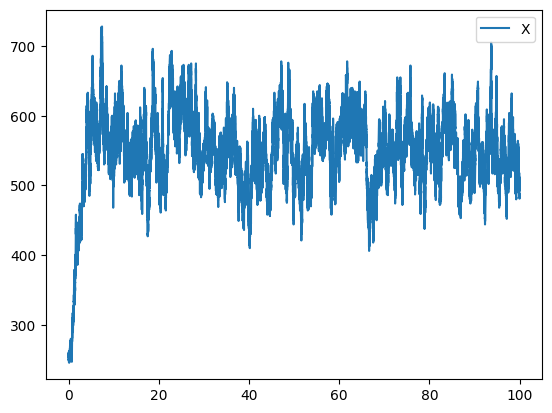

In [51]:
result.plot(spec.model.legend())

In [ ]:
result.t_history.mean()

In [52]:
spec.parameters

{'c1': 3e-07,
 'c2': 0.0001,
 'c3': 0.001,
 'c4': 3.5,
 'N1': 100000.0,
 'N2': 200000.0}

In [76]:
dydt = spec.model.get_dydt(parameters=spec.parameters)
f = lambda x: dydt(0, np.array([x]))

Evaluating expression: c1 * N1 => 0.03
Evaluating expression: c2 => 0.0001
Evaluating expression: c3 * N2 => 200.0
Evaluating expression: c4 => 3.5


In [87]:
f(570)

array([-0.374])

In [84]:
import numpy as np
p = spec.parameters
# this isn't quite right because the powers are (x)(x-1)(x-2) etc
coeff = [-1*p['c2']/6, p['c1']/2*p['N1'], -1*p['c4'], p['c3']*p['N2']]
print(np.roots(coeff))

[566.90790883 247.60236029  85.48973088]


In [93]:
f(566.90790883)

array([7.54671329])

In [89]:
f(248.60236029)

array([0.21816211])